In [1]:
import random
from collections import deque
from copy import deepcopy

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from IPython.display import clear_output

In [2]:
SEED = 1
BATCH_SIZE = 256
LR = 0.0003
UP_COEF = 0.25
EX_COEF = 2.0
IN_COEF = 1.0
UP_PROP = 0.25
GAMMA = 0.99
EPS = np.finfo(np.float).eps

# set device
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

# random seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)

In [3]:
class DuelingDQN(nn.Module):
    def __init__(self, obs_space, action_space):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(obs_space, obs_space*10),
            nn.SELU()
        )
        self.val = nn.Sequential(
            nn.Linear(obs_space*10, 512),
            nn.SELU(),
            nn.Linear(512, 512),
            nn.SELU(),
            nn.Linear(512, 1)
        )
        self.adv = nn.Sequential(
            nn.Linear(obs_space*10, 512),
            nn.SELU(),
            nn.Linear(512, 512),
            nn.SELU(),
            nn.Linear(512, action_space)
        )

    def forward(self, x):
        out = self.head(x)
        val_out = self.val(out).reshape(out.shape[0], 1)
        adv_out = self.adv(out).reshape(out.shape[0], -1)
        adv_mean = adv_out.mean(dim=1, keepdim=True)
        q = val_out + adv_out - adv_mean

        return q


class RandomNet(nn.Module):
    def __init__(self, obs_space):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(obs_space, obs_space*10),
            nn.SELU()
        )
        self.fc = nn.Sequential(
            nn.Linear(obs_space*10, 512)
        )

    def forward(self, x):
        out = self.head(x)
        obs_feature = self.fc(out).reshape(out.shape[0], -1)

        return obs_feature


class PredictNet(nn.Module):
    def __init__(self, obs_space):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(obs_space, obs_space*10),
            nn.SELU()
        )

        self.fc = nn.Sequential(
            nn.Linear(obs_space*10, 512),
            nn.SELU(),
            nn.Linear(512, 512),
            nn.SELU(),
            nn.Linear(512, 512)
        )

    def forward(self, x):
        out = self.head(x)
        obs_feature = self.fc(out).reshape(out.shape[0], -1)

        return obs_feature

In [4]:
m_losses = []
f_losses = []
losses = []

def learn(net, tgt_net, pred_net, rand_net, optimizer, rep_memory):
    global mean
    global std

    net.train()
    tgt_net.train()
    pred_net.train()
    rand_net.train()

    train_data = random.sample(rep_memory, BATCH_SIZE)

    dataloader = DataLoader(
        train_data,
        batch_size=BATCH_SIZE,
        pin_memory=use_cuda
    )

    # double DQN
    for i, (s, a, r_ex, r_in, _s, d) in enumerate(dataloader):
        s_batch = s.to(device).float()
        a_batch = a.detach().to(device).long()
        _s_batch = _s.to(device).float()

        _s_norm = normalize_obs(_s.detach().cpu().numpy(), mean, std)
        _s_norm_batch = torch.tensor(_s_norm).to(device).float()
        r_ex_batch = r_ex.to(device).float()
        r_in_batch = r_in.to(device).float()
        r_batch = EX_COEF * 0.5 * r_ex_batch + IN_COEF * 0.5 * r_in_batch
        done_mask = 1. - d.to(device).float()

        _q_batch = net(_s_batch)
        _a_batch = torch.argmax(_q_batch, dim=1)
        pred_f = pred_net(_s_norm_batch)

        with torch.no_grad():
            _q_batch_tgt = tgt_net(_s_batch)
            action_space = _q_batch_tgt.shape[1]
            _q_best_tgt = _q_batch_tgt[range(BATCH_SIZE), _a_batch]
            rand_f = rand_net(_s_norm_batch)

        q_batch = net(s_batch)
        q_acting = q_batch[range(BATCH_SIZE), a_batch]

        # loss
        m_loss = ((r_batch + GAMMA * done_mask *_q_best_tgt) - q_acting).pow(2).mean()
        m_losses.append(m_loss)

        f_loss = (pred_f - rand_f).pow(2)
        mask = torch.rand(f_loss.shape[1]).to(device)
        mask = (mask < UP_PROP).to(device).float()
        f_loss = (f_loss * mask).sum() / mask.sum().clamp(min=1)
        f_losses.append(f_loss)

        loss = m_loss + f_loss
        losses.append(loss)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def select_action(obs, tgt_net):
    tgt_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        q = target_net(state)
        action = torch.argmax(q)

    return action.item()


def get_norm_params(obs_memory):
    global obs_apace

    obses = [[] for _ in range(obs_space)]
    for obs in obs_memory:
        for j in range(obs_space):
            obses[j].append(obs[j])

    mean = np.zeros(obs_space, np.float32)
    std = np.zeros(obs_space, np.float32)
    for i, obs_ in enumerate(obses):
        mean[i] = np.mean(obs_)
        std[i] = np.std(obs_)

    return mean, np.clip(std, a_min=EPS, a_max=None)


def normalize_obs(obs, mean, std):
    norm_obs = (obs - mean) / std

    return np.clip(norm_obs, -5, 5)


def calculate_reward_in(pred_net, rand_net, obs):
    global mean
    global std

    norm_obs = normalize_obs(obs, mean, std)
    state = torch.tensor([norm_obs]).to(device).float()
    with torch.no_grad():
        pred_obs = pred_net(state)
        rand_obs = rand_net(state)
        reward = (pred_obs - rand_obs).pow(2).sum()
        clipped_reward = torch.clamp(reward, -1, 1)

    return clipped_reward.item()


def plot():
    clear_output(True)
    plt.figure(figsize=(16, 5))
    plt.subplot(131)
    plt.plot(rewards)
    plt.title('Extrinsic Reward')
    plt.subplot(132)
    plt.plot(rewards_in)
    plt.title('Intrinsic Reward')
    plt.subplot(133)
    plt.plot(losses)
    plt.title('Loss')
    plt.show()

## Main

In [5]:
# make an environment
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('LunarLander-v2')

env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n

# hyperparameter
n_episodes = 1000
learn_start = 1500
memory_size = 50000
update_frq = 1
use_eps_decay = False
epsilon = 0.001
eps_min = 0.001
decay_rate = 0.0001
n_eval = env.spec.trials

# global values
init_steps = 0
total_steps = 0
learn_steps = 0
rewards = []
rewards_in = []
reward_eval = deque(maxlen=n_eval)
is_learned = False
is_solved = False
is_init_roll = True

# make four nerual networks
net = DuelingDQN(obs_space, action_space).to(device)
target_net = deepcopy(net)
pred_net = PredictNet(obs_space).to(device)
rand_net = RandomNet(obs_space).to(device)

# make a optimizer
total_params = list(net.parameters()) + list(pred_net.parameters()) 
optimizer = torch.optim.Adam(total_params, lr=LR)

# make memory
rep_memory = deque(maxlen=memory_size)
obs_memory = deque(maxlen=learn_start)

/home/jay/anaconda3/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [6]:
use_cuda

True

In [7]:
env.spec.max_episode_steps

500

In [8]:
env.spec.trials

100

In [9]:
env.spec.reward_threshold

475.0

In [10]:
# rollout
while True:
    obs = env.reset()
    done = False
    while not done:
#         env.render()
        action = env.action_space.sample()
        _obs, _, done, _ = env.step(action)
        obs_memory.append(_obs)
        obs = _obs
        init_steps += 1
        if init_steps == learn_start:
            mean, std = get_norm_params(obs_memory)
            obs_memory.clear()
            is_init_roll = False
            break
    if not is_init_roll:
        break

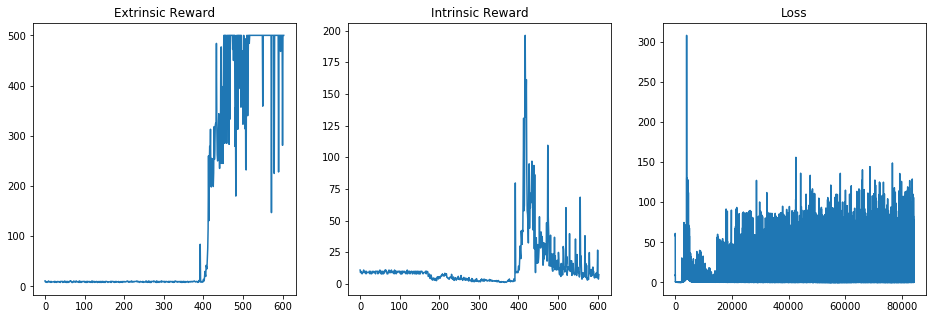


CartPole-v1 is sloved! 604 Episode in 85734 steps


In [11]:
# play!
for i in range(1, n_episodes + 1):
    obs = env.reset()
    done = False
    ep_reward = 0
    ep_reward_in = 0.
    while not done:
#         env.render()
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = select_action(obs, target_net)

        _obs, reward, done, _ = env.step(action)
        
        reward_in = calculate_reward_in(pred_net, rand_net, _obs)

        obs_memory.append(_obs)
        rep_memory.append((obs, action, reward, reward_in, _obs, done))

        obs = _obs
        total_steps += 1
        ep_reward += reward
        ep_reward_in += reward_in
        
        if use_eps_decay:
            epsilon -= epsilon * decay_rate
            epsilon = max(eps_min, epsilon)

        if total_steps % learn_start == 0:
            mean, std = get_norm_params(obs_memory)
        
        if len(rep_memory) >= learn_start:
            if len(rep_memory) == learn_start:
                print('\n====================  Start Learning  ====================\n')
                is_learned = True    
            learn(net, target_net, pred_net, rand_net,
                  optimizer, rep_memory)
            learn_steps += 1

        if learn_steps == update_frq:
            # target smoothing update
            for t, n in zip(target_net.parameters(), net.parameters()):
                t.data = UP_COEF * n.data + (1 - UP_COEF) * t.data
            learn_steps = 0
    if done:
        rewards.append(ep_reward)
        rewards_in.append(ep_reward_in)
        reward_eval.append(ep_reward)
        plot()
#         print('{:3} Episode in {:5} steps, reward {:.2f}, reward_in {:.2f}'.format(
#             i, total_steps, ep_reward, ep_reward_in))

        if len(reward_eval) >= n_eval:
            if np.mean(reward_eval) >= env.spec.reward_threshold:
                print('\n{} is sloved! {:3} Episode in {:3} steps'.format(
                    env.spec.id, i, total_steps))
                torch.save(target_net.state_dict(),
                           f'../test/saved_models/{env.spec.id}_ep{i}_clear_model_dddqn_r.pt')
                break
env.close()

In [12]:
[
    ('CartPole-v0', 355, 0.5),
    ('CartPole-v1', 484, 0.025),
    ('MountainCar-v0', 571, 0.1),
    ('LunarLander-v2', 454, 0.5)
]

[('CartPole-v0', 355, 0.5),
 ('CartPole-v1', 484, 0.025),
 ('MountainCar-v0', 571, 0.1),
 ('LunarLander-v2', 454, 0.5)]